In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

alhanoufalqahtani_electricity_transformer_dataset_path = kagglehub.dataset_download('alhanoufalqahtani/electricity-transformer-dataset')

print('Data source import complete.')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
data = pd.read_csv("/kaggle/input/electricity-transformer-dataset/ETTm1.csv")

In [ ]:
print(f"Dataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")
print(data.head())

data['date'] = pd.to_datetime(data['date'])
print(f"\nMissing values:\n{data.isnull().sum()}")
data.dropna(inplace=True)


Dataset shape: (69680, 8)
Columns: ['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 00:15:00  5.760  2.076  1.492  0.426  4.264  1.401  30.459999
2  2016-07-01 00:30:00  5.760  1.942  1.492  0.391  4.234  1.310  30.038000
3  2016-07-01 00:45:00  5.760  1.942  1.492  0.426  4.234  1.310  27.013000
4  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001

Missing values:
date    0
HUFL    0
HULL    0
MUFL    0
MULL    0
LUFL    0
LULL    0
OT      0
dtype: int64


In [ ]:
# Extract time features
data['hour'] = data['date'].dt.hour
data['day_of_week'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month

print(f"\nData after preprocessing: {data.shape}")


Data after preprocessing: (69680, 11)


In [ ]:
data_naive = data[['date', 'OT']].copy(deep=True)
data_naive['prev_OT'] = data_naive['OT'].shift(1)
data_naive.dropna(inplace=True)
data_naive['difference'] = data_naive['OT'] - data_naive['prev_OT']
data_naive['square_error'] = data_naive['difference'] ** 2

naive_mse = data_naive['square_error'].mean()
print(f'Naive Approach Mean Square Error: {naive_mse:.4f}')

Naive Approach Mean Square Error: 0.1984


In [ ]:
feature_columns = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']

input_data = data[feature_columns].copy()

# Hyperparameters
T = 96 #Sequence length
D = input_data.shape[1] #Input dimensions
N = len(input_data) - T #Total sequences

In [ ]:
print(f"Sequence length (T): {T}")
print(f"Input dimensions (D): {D}")
print(f"Total sequences (N): {N}")

Sequence length (T): 96
Input dimensions (D): 7
Total sequences (N): 69584


In [ ]:
# Train/Val/Test split
train_size = int(len(input_data) * 0.70)
val_size = int(len(input_data) * 0.15)
test_size = N - train_size - val_size

In [ ]:
print(f"\nTrain size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")


Train size: 48776
Validation size: 10452
Test size: 10356


In [ ]:
# Fit scaler on training data only
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])

# Transform all data using training statistics
input_data_scaled = scaler.transform(input_data)

In [ ]:
print(f" Scaler fit on training data only (indices 0 to {train_size + T - 1})")

 Scaler fit on training data only (indices 0 to 48871)


In [ ]:
# Extract the index of OT column to scale targets consistently
ot_column_idx = feature_columns.index('OT')
# Get scaled OT values for targets
targets_scaled = input_data_scaled[:, ot_column_idx]

In [ ]:
def create_sequences(data, targets, start_idx, end_idx, T):
    """Create input sequences and targets"""
    n_sequences = end_idx - start_idx
    X = np.zeros((n_sequences, T, data.shape[1]))
    y = np.zeros((n_sequences, 1))

    for i in range(n_sequences):
        t = i + start_idx
        X[i, :, :] = data[t:t+T]
        y[i] = targets[t+T]

    return X, y

In [ ]:
# Create sequences
X_train, y_train = create_sequences(input_data_scaled, targets_scaled, 0, train_size, T)
X_val, y_val = create_sequences(input_data_scaled, targets_scaled, train_size, train_size + val_size, T)
X_test, y_test = create_sequences(input_data_scaled, targets_scaled, train_size + val_size, N, T)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_val = torch.from_numpy(X_val.astype(np.float32))
y_val = torch.from_numpy(y_val.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

print(f"Tensor shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Tensor shapes:
X_train: torch.Size([48776, 96, 7]), y_train: torch.Size([48776, 1])
X_val: torch.Size([10452, 96, 7]), y_val: torch.Size([10452, 1])
X_test: torch.Size([10356, 96, 7]), y_test: torch.Size([10356, 1])


In [ ]:
BATCH_SIZE = 64

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches per epoch: {len(train_loader)}")



Batch size: 64
Training batches per epoch: 762


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout=0.2):
        super(LSTM, self).__init__()
        self.M = hidden_dim
        self.L = layer_dim

        self.rnn = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=layer_dim,
            batch_first=True,
            dropout=dropout if layer_dim > 1 else 0)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
hidden_dim = 128
layer_dim = 2
output_dim = 1

model = LSTM(D, hidden_dim, layer_dim, output_dim, dropout=0.2)
model.to(device)

LSTM(
  (rnn): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def train(model, train_loader, val_loader, learning_rate=0.001, epochs=100, patience=15):

    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_batches = []

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss_batches.append(loss.item())

        avg_train_loss = np.mean(train_loss_batches)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss_batches = []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss_batches.append(loss.item())

        avg_val_loss = np.mean(val_loss_batches)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1

        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        if patience_counter >= patience:
            print(f'\nEarly stopping at epoch {epoch+1}')
            break


    model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses


In [ ]:
print(f"\nModel: {sum(p.numel() for p in model.parameters())} parameters")


Model: 202369 parameters


In [ ]:
train_losses, val_losses = train(
    model, train_loader, val_loader,
    learning_rate=0.001, epochs=100, patience=15
)

Epoch 5/100 - Train Loss: 0.0047, Val Loss: 0.0014
Epoch 10/100 - Train Loss: 0.0044, Val Loss: 0.0014
Epoch 15/100 - Train Loss: 0.0039, Val Loss: 0.0014
Epoch 20/100 - Train Loss: 0.0038, Val Loss: 0.0014
Epoch 25/100 - Train Loss: 0.0036, Val Loss: 0.0014
Epoch 30/100 - Train Loss: 0.0035, Val Loss: 0.0013
Epoch 35/100 - Train Loss: 0.0035, Val Loss: 0.0014

Early stopping at epoch 38


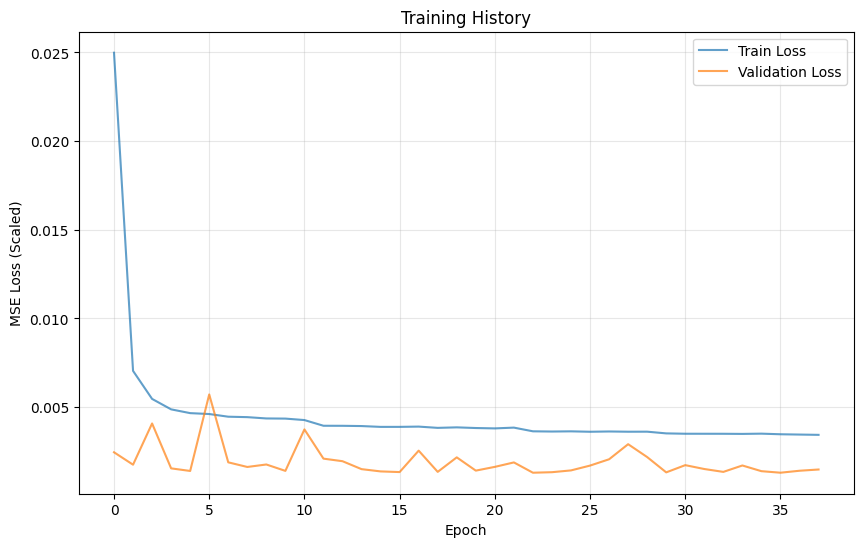

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', alpha=0.7)
plt.plot(val_losses, label='Validation Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (Scaled)')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
model.eval()
test_predictions_scaled = []
test_targets_scaled = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        test_predictions_scaled.extend(outputs.cpu().numpy().flatten())
        test_targets_scaled.extend(batch_y.numpy().flatten())

test_predictions_scaled = np.array(test_predictions_scaled)
test_targets_scaled = np.array(test_targets_scaled)

In [ ]:
# Get scaler parameters for OT column
ot_mean = scaler.mean_[ot_column_idx]
ot_std = scaler.scale_[ot_column_idx]

# Inverse transform: original = scaled * std + mean
test_predictions = test_predictions_scaled * ot_std + ot_mean
test_targets = test_targets_scaled * ot_std + ot_mean

print(f"Predictions and targets converted to original scale")

# Calculate metrics on ORIGINAL scale
mse = np.mean((test_targets - test_predictions) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(test_targets - test_predictions))
r2   = r2_score(test_targets, test_predictions)

print(f"  MSE:  {mse:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:  {r2:.4f}")


Predictions and targets converted to original scale
  MSE:  0.1101
  RMSE: 0.3318
  MAE:  0.2238
  R2:  0.9864


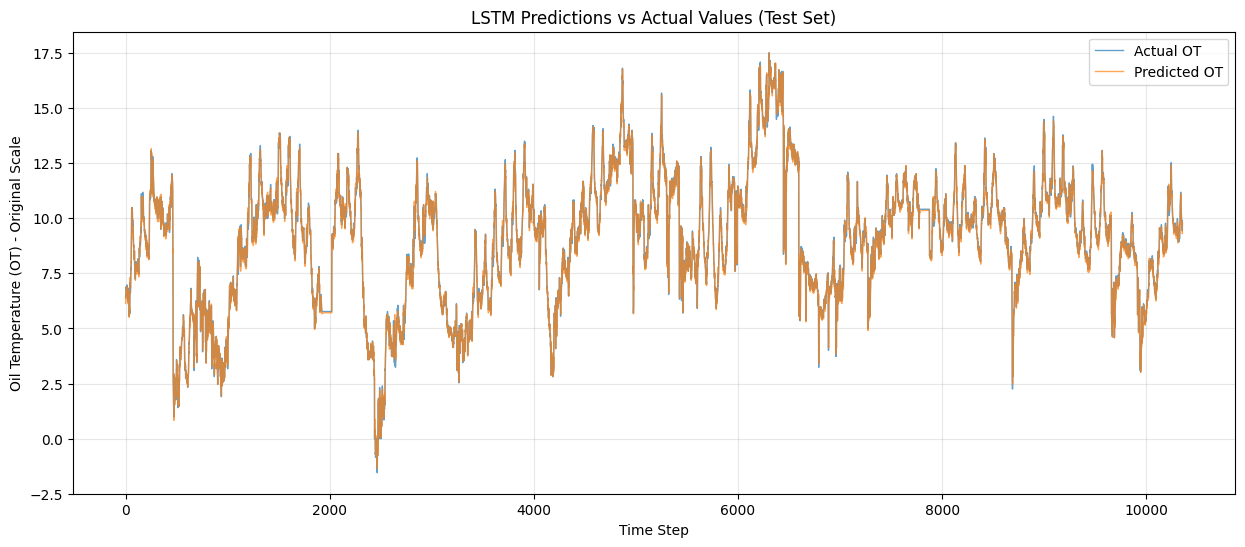

In [ ]:
plt.figure(figsize=(15, 6))
plot_samples = min( len(test_predictions), len(test_predictions))
plt.plot(test_targets[:plot_samples], label='Actual OT', linewidth=1, alpha=0.7)
plt.plot(test_predictions[:plot_samples], label='Predicted OT', linewidth=1, alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Oil Temperature (OT) - Original Scale')
plt.title('LSTM Predictions vs Actual Values (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

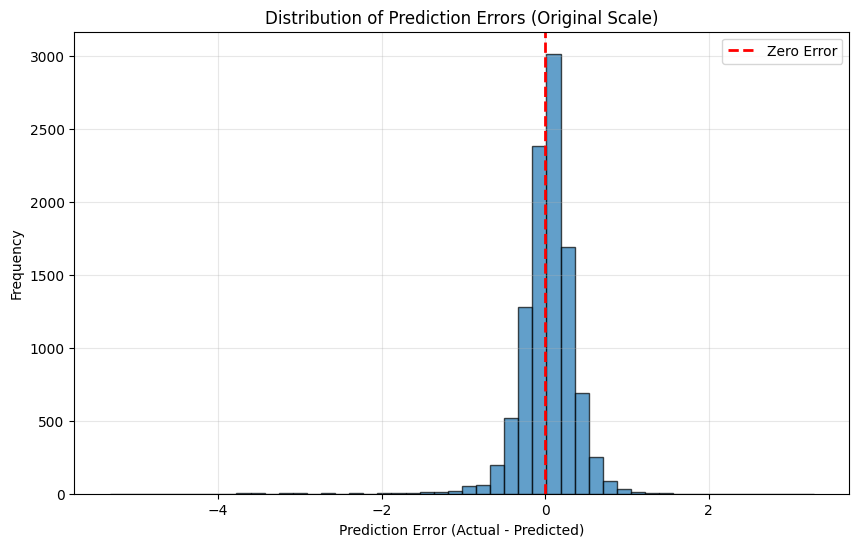

In [ ]:
errors = test_targets - test_predictions
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Original Scale)')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

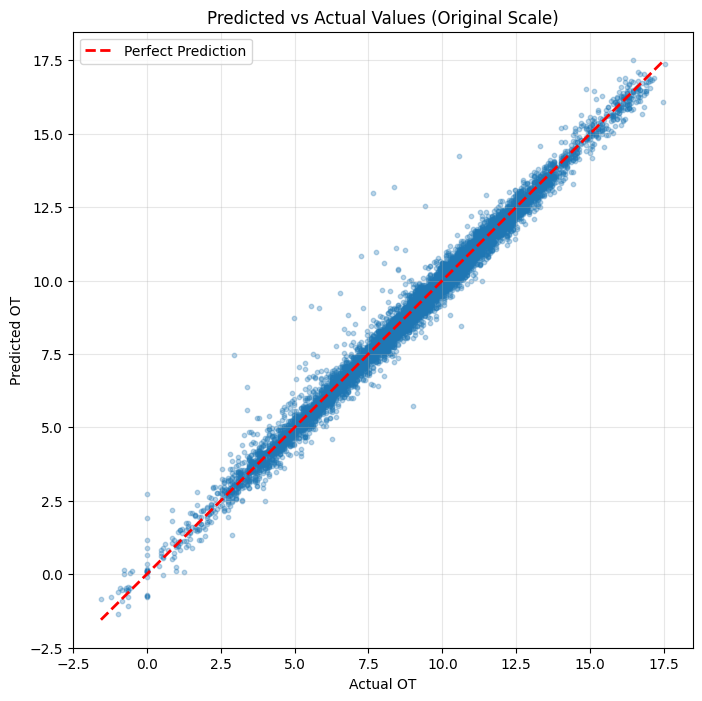

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(test_targets, test_predictions, alpha=0.3, s=10)
plt.plot([test_targets.min(), test_targets.max()],
         [test_targets.min(), test_targets.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual OT')
plt.ylabel('Predicted OT')
plt.title('Predicted vs Actual Values (Original Scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()